# **Laptop Prices Prediction**

**Dataset source: https://www.kaggle.com/datasets/anubhavgoyal10/laptop-prices-dataset**

# **Preparation**

In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!mkdir -p ~/.kaggle

In [3]:
!cp kaggle.json ~/.kaggle/

In [4]:
!chmod 600 /root/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d anubhavgoyal10/laptop-prices-dataset

  0% 0.00/9.08k [00:00<?, ?B/s]
100% 9.08k/9.08k [00:00<00:00, 31.3MB/s]


In [ ]:
!unzip /content/laptop-prices-dataset.zip

In [273]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

In [274]:
df = pd.read_csv('/content/laptopPrice.csv')

# **Exploratory Data Analysis**

## **1. Variable Descriptions**

In [275]:
df.head(3)

,brand,processor_brand,processor_name,processor_gnrtn,ram_gb,ram_type,ssd,hdd,os,os_bit,graphic_card_gb,weight,warranty,Touchscreen,msoffice,Price,rating,Number of Ratings,Number of Reviews
0,ASUS,Intel,Core i3,10th,4 GB,DDR4,0 GB,1024 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,34649,2 stars,3,0
1,Lenovo,Intel,Core i3,10th,4 GB,DDR4,0 GB,1024 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,38999,3 stars,65,5
2,Lenovo,Intel,Core i3,10th,4 GB,DDR4,0 GB,1024 GB,Windows,64-bit,0 GB,Casual,No warranty,No,No,39999,3 stars,8,1


In [276]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 823 entries, 0 to 822
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   brand              823 non-null    object
 1   processor_brand    823 non-null    object
 2   processor_name     823 non-null    object
 3   processor_gnrtn    823 non-null    object
 4   ram_gb             823 non-null    object
 5   ram_type           823 non-null    object
 6   ssd                823 non-null    object
 7   hdd                823 non-null    object
 8   os                 823 non-null    object
 9   os_bit             823 non-null    object
 10  graphic_card_gb    823 non-null    object
 11  weight             823 non-null    object
 12  warranty           823 non-null    object
 13  Touchscreen        823 non-null    object
 14  msoffice           823 non-null    object
 15  Price              823 non-null    int64 
 16  rating             823 non-null    object
 1

In [277]:
df.describe()

,Price,Number of Ratings,Number of Reviews
count,823.000000,823.000000,823.000000
mean,76745.177400,315.301337,37.609964
std,45101.790525,1047.382654,121.728017
min,16990.000000,0.000000,0.000000
25%,46095.000000,0.000000,0.000000
50%,64990.000000,17.000000,2.000000
75%,89636.000000,139.500000,18.000000
max,441990.000000,15279.000000,1947.000000


In [278]:
for col in df.columns:
  if col == 'Price' or col == 'Number of Ratings' or col == 'Number of Reviews':
    continue
  else:
    print(col)
    print(df[col].unique())

brand
['ASUS' 'Lenovo' 'acer' 'Avita' 'HP' 'DELL' 'MSI' 'APPLE']
processor_brand
['Intel' 'AMD' 'M1']
processor_name
['Core i3' 'Core i5' 'Celeron Dual' 'Ryzen 5' 'Core i7' 'Core i9' 'M1'
 'Pentium Quad' 'Ryzen 3' 'Ryzen 7' 'Ryzen 9']
processor_gnrtn
['10th' 'Not Available' '11th' '7th' '8th' '9th' '4th' '12th']
ram_gb
['4 GB' '8 GB' '16 GB' '32 GB']
ram_type
['DDR4' 'LPDDR4' 'LPDDR4X' 'DDR5' 'DDR3' 'LPDDR3']
ssd
['0 GB' '512 GB' '256 GB' '128 GB' '1024 GB' '2048 GB' '3072 GB']
hdd
['1024 GB' '0 GB' '512 GB' '2048 GB']
os
['Windows' 'DOS' 'Mac']
os_bit
['64-bit' '32-bit']
graphic_card_gb
['0 GB' '2 GB' '4 GB' '6 GB' '8 GB']
weight
['Casual' 'ThinNlight' 'Gaming']
warranty
['No warranty' '1 year' '2 years' '3 years']
Touchscreen
['No' 'Yes']
msoffice
['No' 'Yes']
rating
['2 stars' '3 stars' '4 stars' '5 stars' '1 star']


## **2. Missing Value & Outlier Handling**

In [279]:
df.isna().sum()

brand                0
processor_brand      0
processor_name       0
processor_gnrtn      0
ram_gb               0
ram_type             0
ssd                  0
hdd                  0
os                   0
os_bit               0
graphic_card_gb      0
weight               0
warranty             0
Touchscreen          0
msoffice             0
Price                0
rating               0
Number of Ratings    0
Number of Reviews    0
dtype: int64

From this above cell output, we can see that there is no missing value on this dataset.

<Axes: xlabel='Number of Ratings'>

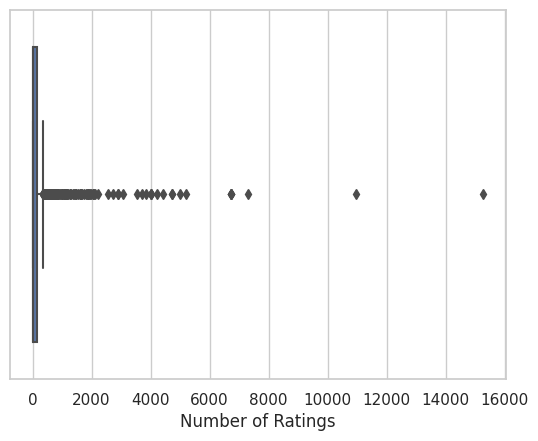

In [280]:
sns.boxplot(x=df['Number of Ratings'])

<Axes: xlabel='Number of Reviews'>

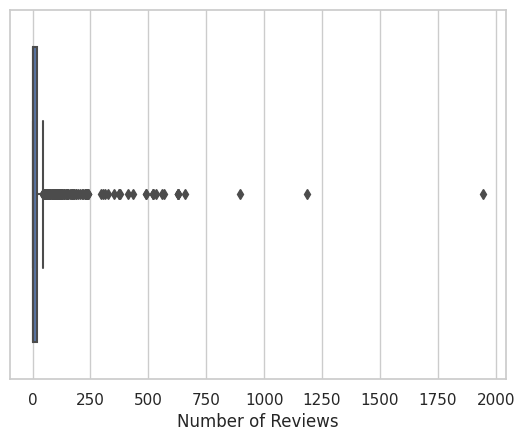

In [281]:
sns.boxplot(x=df['Number of Reviews'])

<Axes: xlabel='Price'>

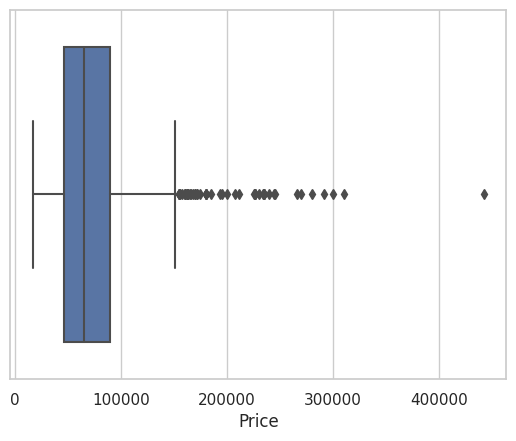

In [282]:
sns.boxplot(x=df['Price'])

From the above plots, we can see that all of the numerical features have outliers. So, we need to remove them first.

In [283]:
# Outlier handling using IQR method
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df = df[~((df<(Q1-1.5*IQR))|(df>(Q3+1.5*IQR))).any(axis=1)]

In [284]:
print(f'Shape of the data after outlier removal: {df.shape}')

Shape of the data after outlier removal: (634, 19)


## **3. Univariate Analysis**

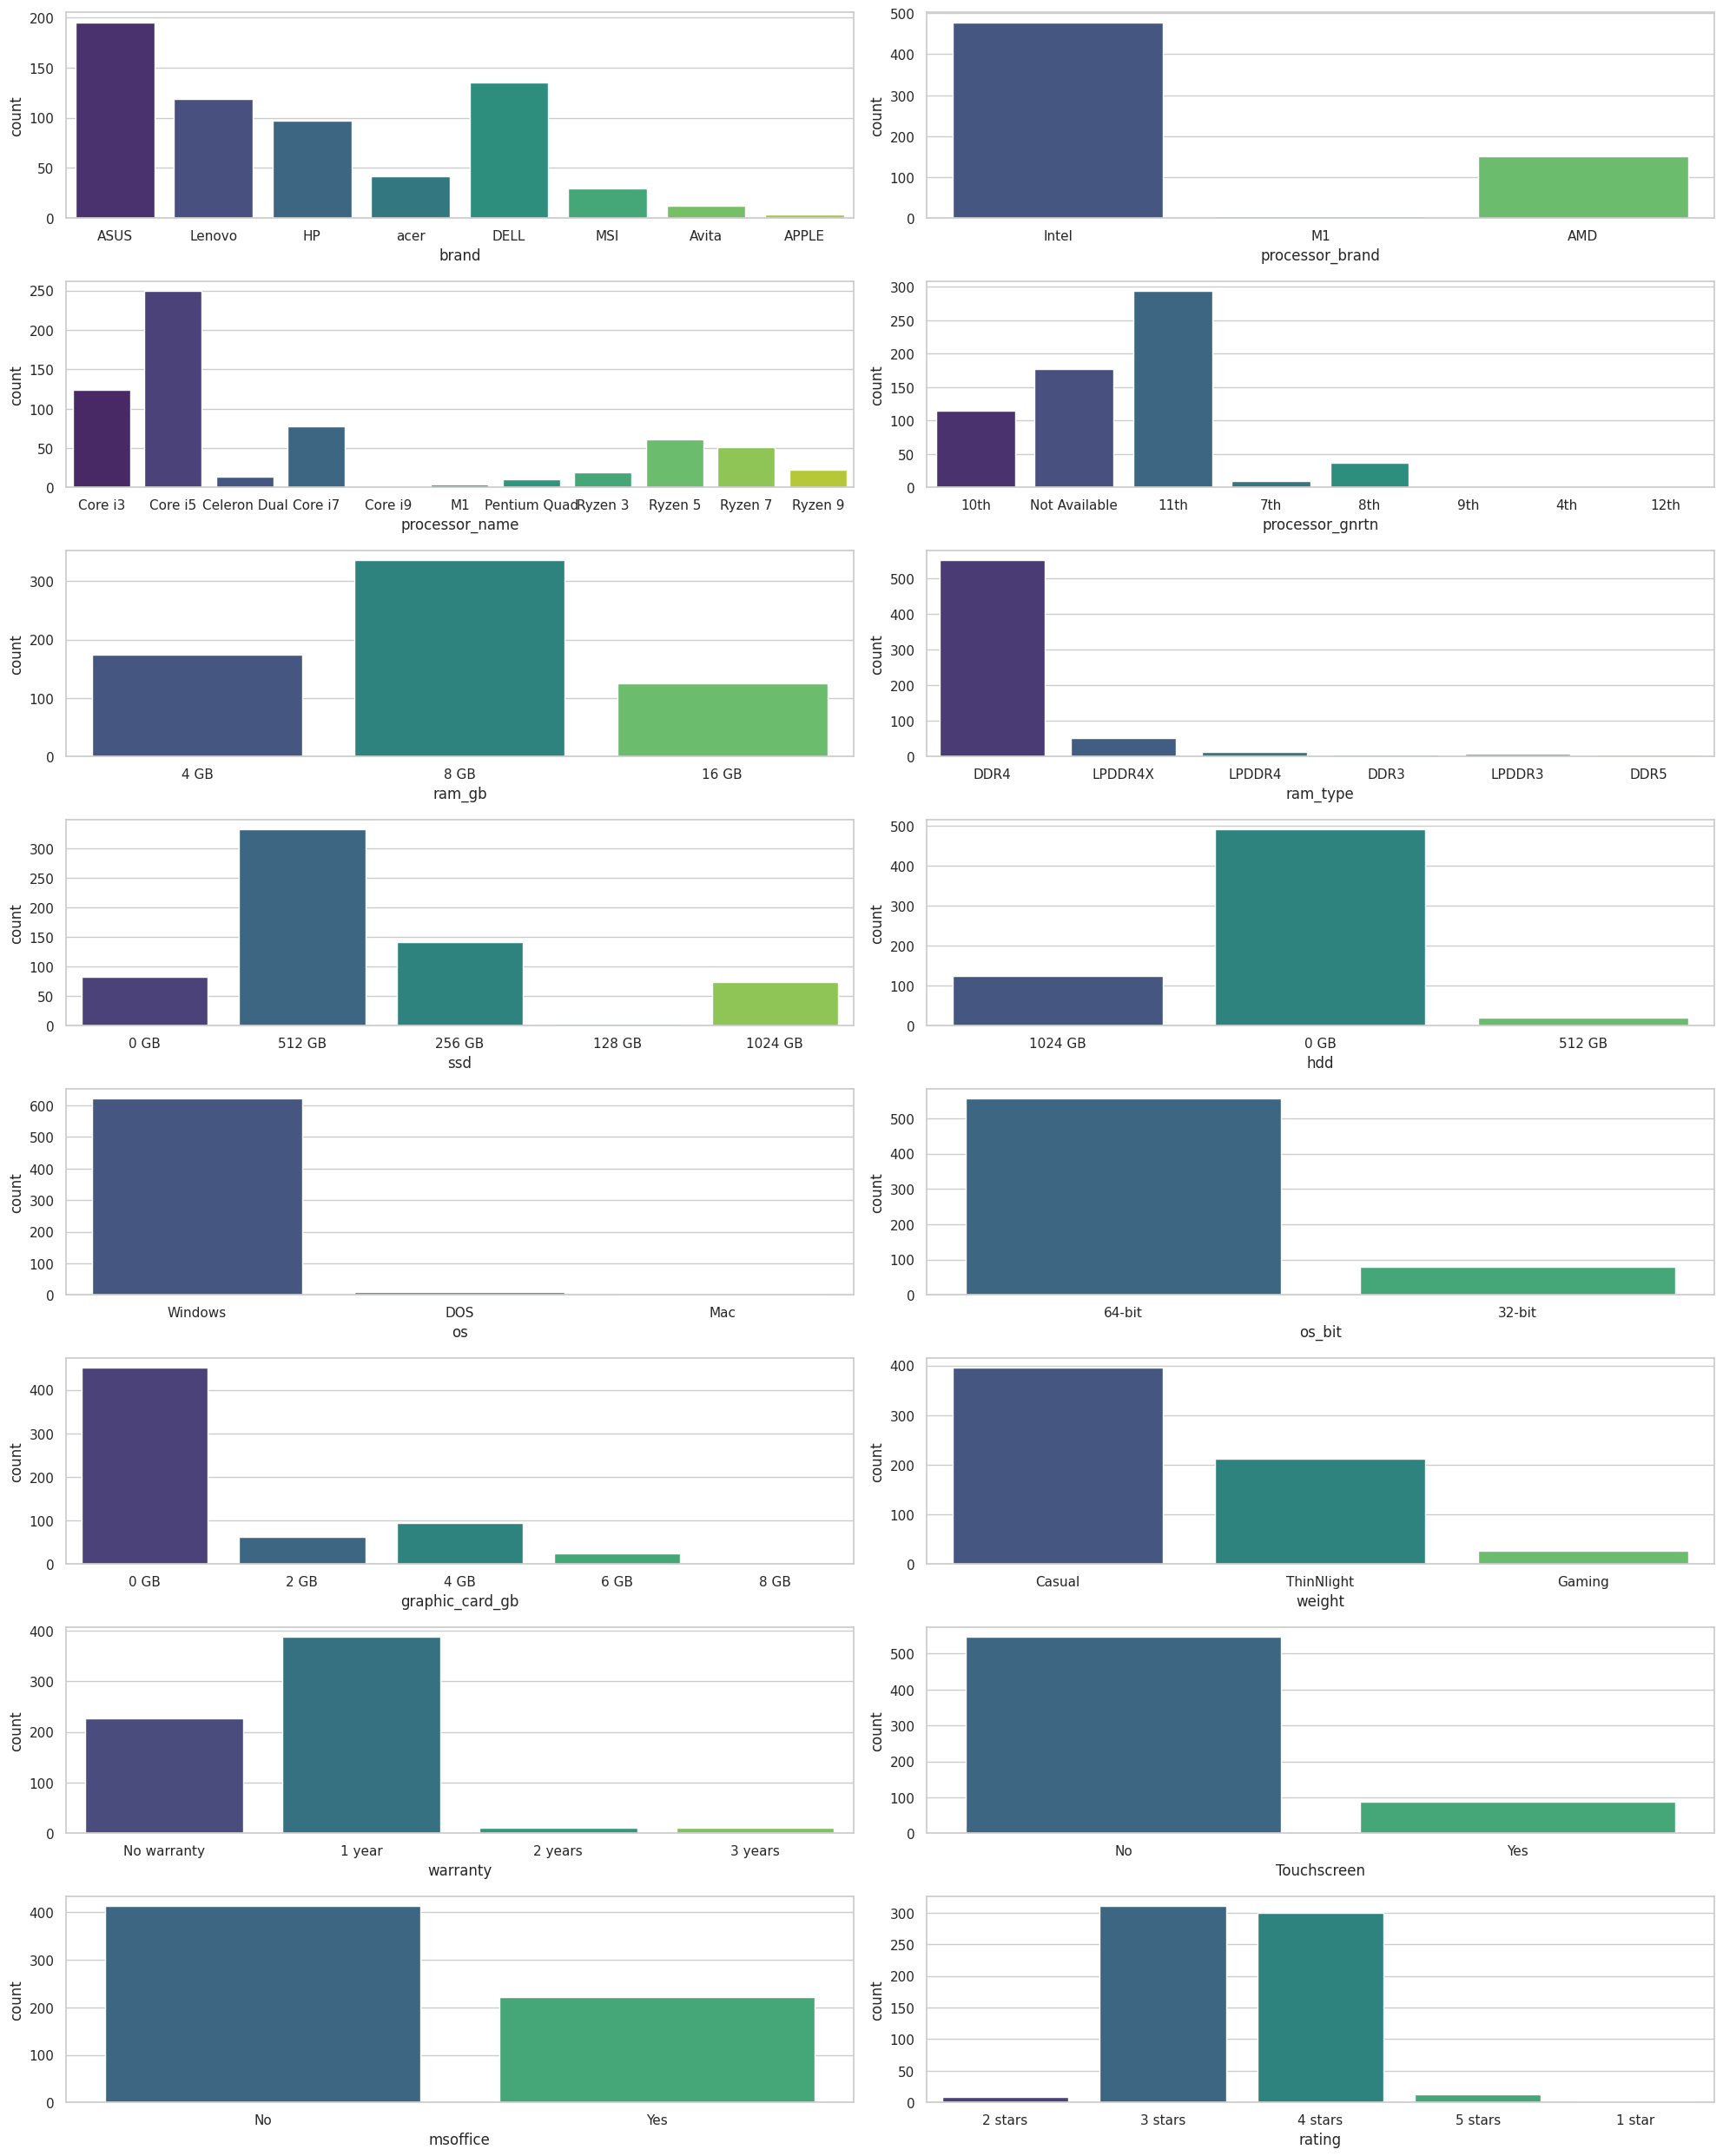

In [285]:
sns.set(style="whitegrid")  # Set the style of the plots

cat_features = df.select_dtypes(include='object').columns.to_list()

num_plots = len(cat_features)  # Get the number of cat_features
num_rows = 8
num_cols = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 25))  # Create subplots

for i, column in enumerate(cat_features):
    row = i // num_cols  # Calculate the row index
    col = i % num_cols  # Calculate the column index

    # Create a count plot for each column
    ax = axes[row, col] if num_plots > 1 else axes  # Use a single axis if there is only one plot
    sns.countplot(x=column, data=df, palette="viridis", ax=ax)  # Count plot for the current column

# Remove any empty subplots
if num_plots < (num_rows * num_cols):
    for i in range(num_plots, num_rows * num_cols):
        fig.delaxes(axes.flatten()[i])

# Adjust the layout and spacing of the subplots
plt.tight_layout()

# Show the plot
plt.show()

**Several insights from the above plots:**

- The top 4 common brands are ASUS, DELL, Lenovo, and HP
- There are three different kinds of the processor brand, there are Intel, AMD, and M1
- The most common processor name is Core i5
- Most laptops aren't supported by the graphics card
- The most common OS is Windows 64-bit
- The laptop rating values centered on 3 and 4 stars.

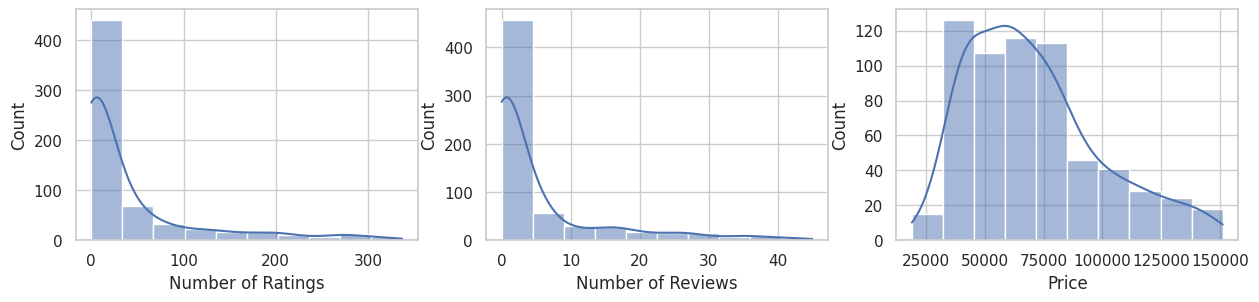

In [286]:
fig, axes = plt.subplots(1, 3, figsize=(15, 3))

sns.histplot(df['Number of Ratings'], kde=True, bins=10, ax=axes[0])
sns.histplot(df['Number of Reviews'], kde=True, bins=10, ax=axes[1])
sns.histplot(df['Price'], kde=True, bins=10, ax=axes[2])

plt.show()

**Several insights from the above plots:**

- The distribution of the `Number of Ratings` and `Number of Reviews` columns are right-skewed
- About half of the laptop price lies on below $80000.

## **4. Multivariate Analysis**

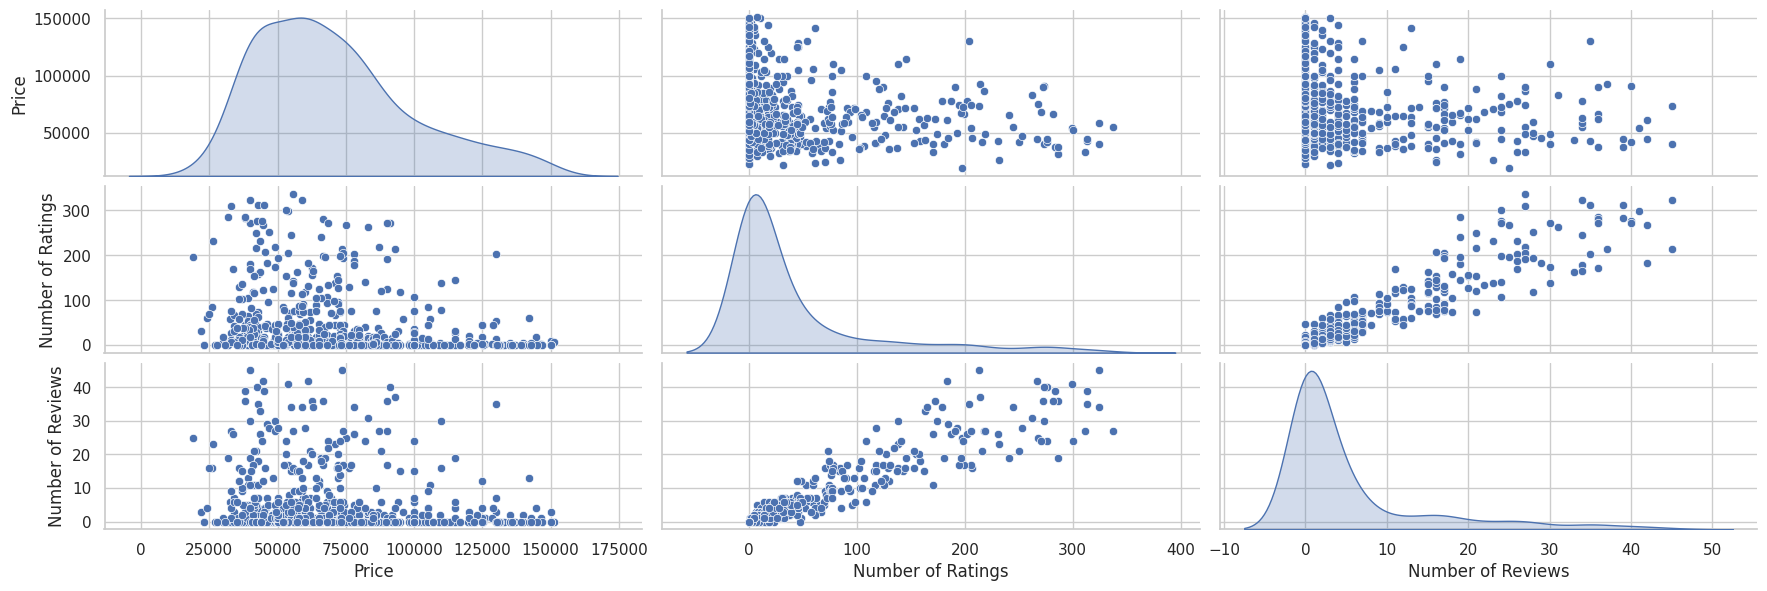

In [287]:
sns.pairplot(df, diag_kind='kde', height=2, aspect=3)

**Insight from the above plots:**

- `Number of Ratings` and `Number of Reviews` features seems to have high correlation each other, but have low correlation with the `Price` column.

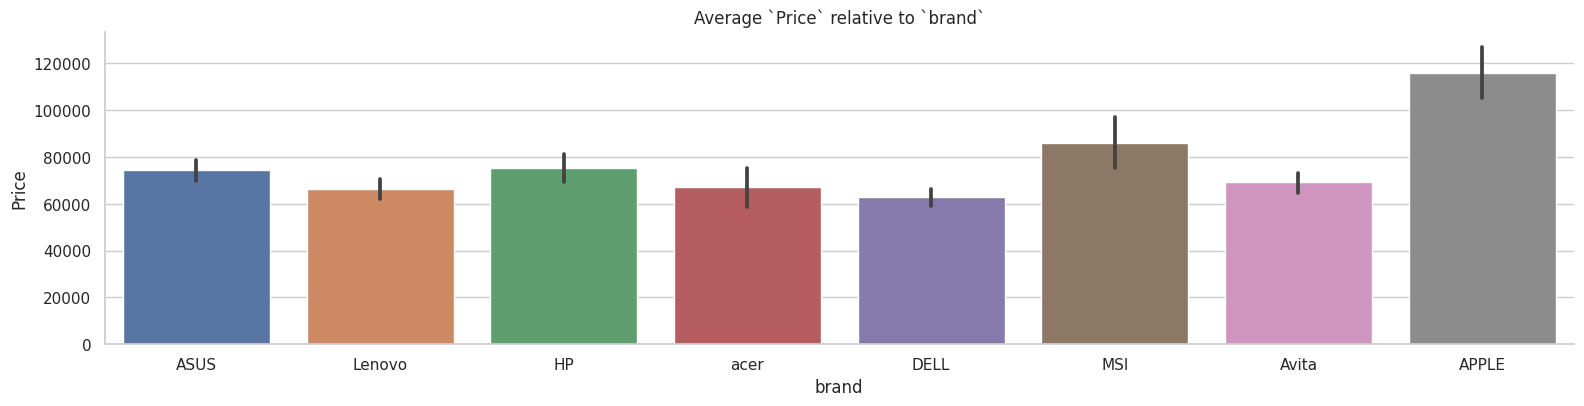

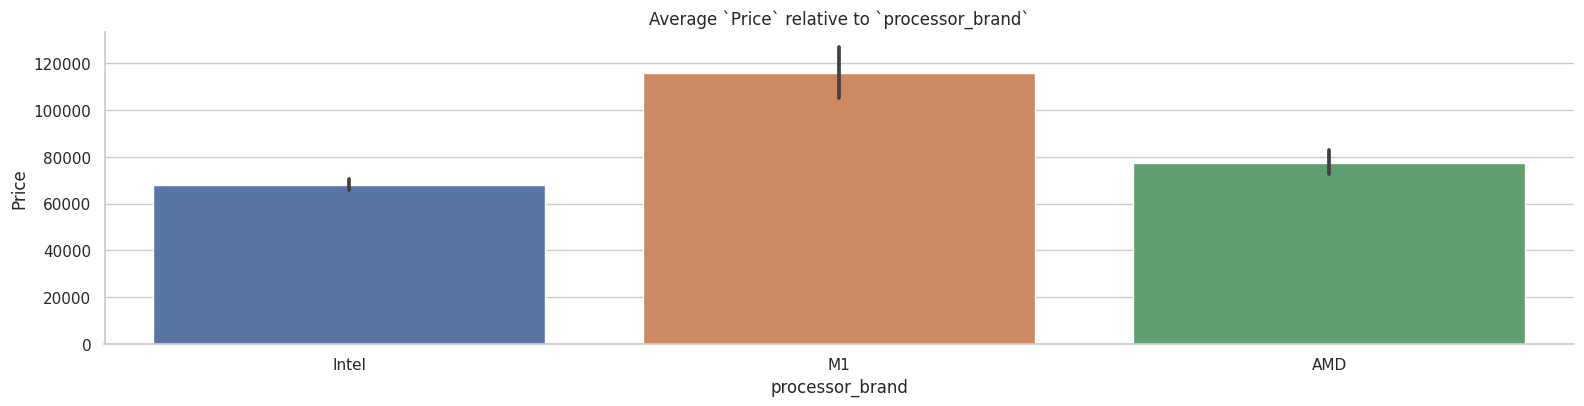

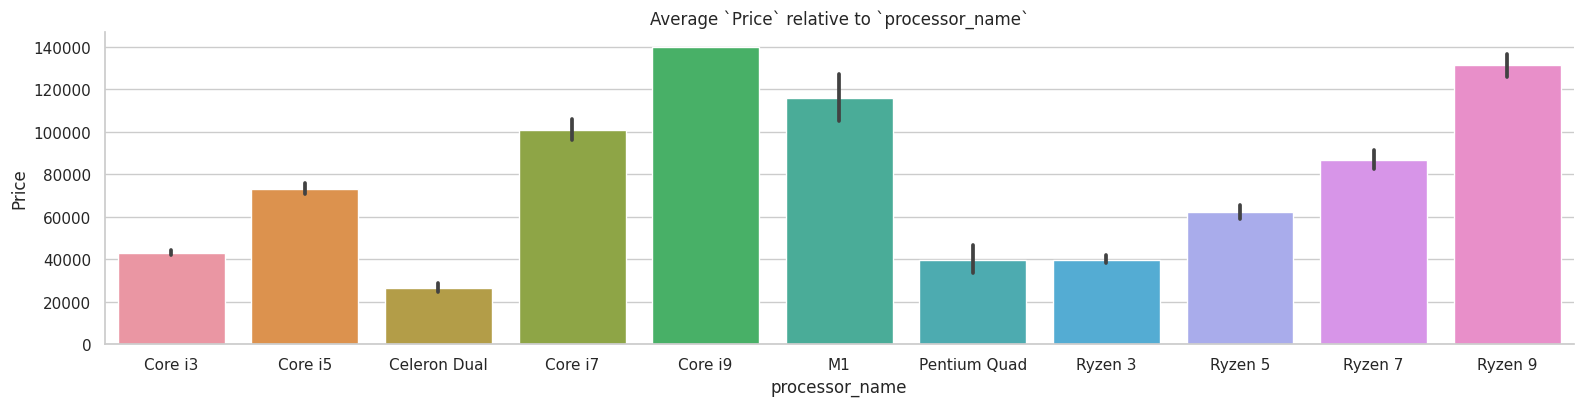

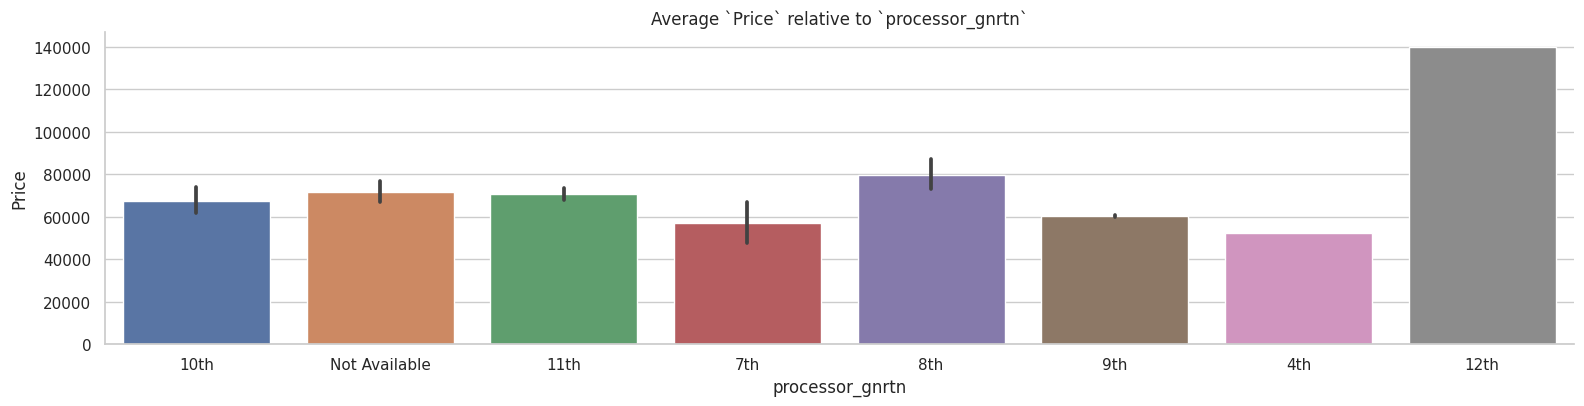

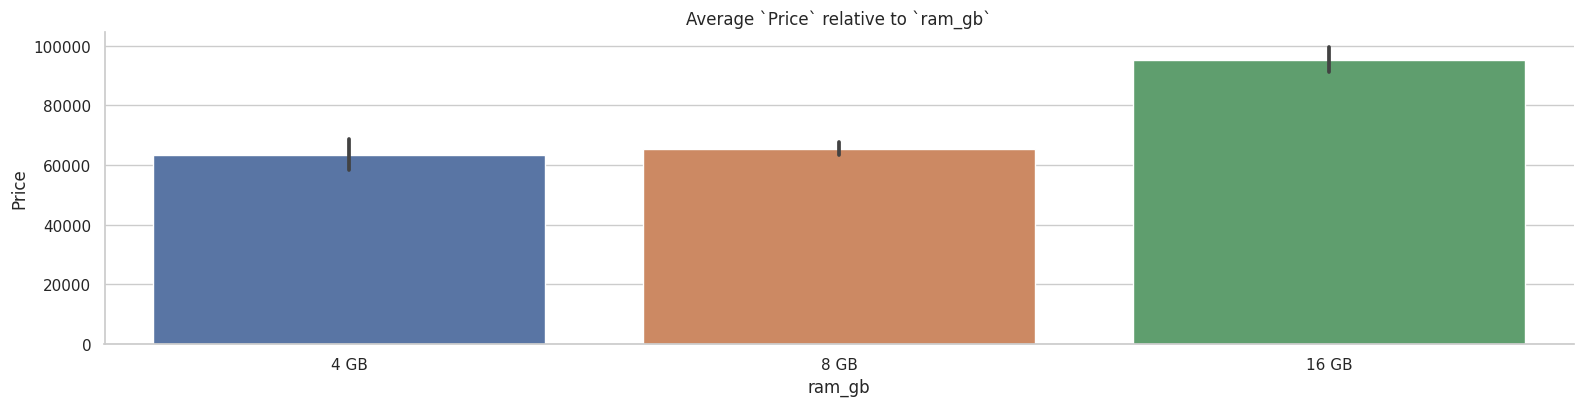

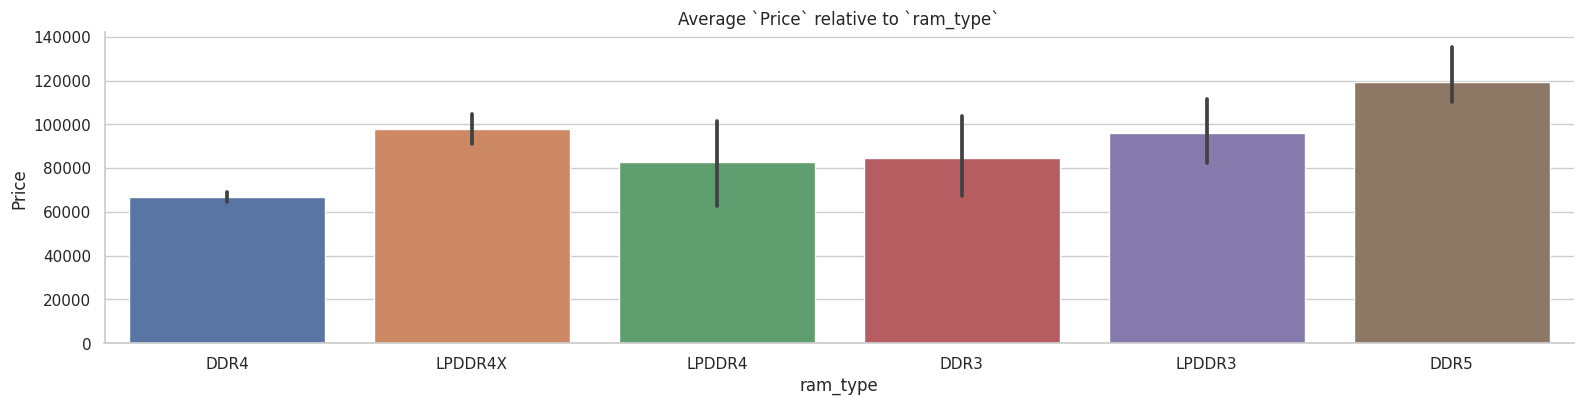

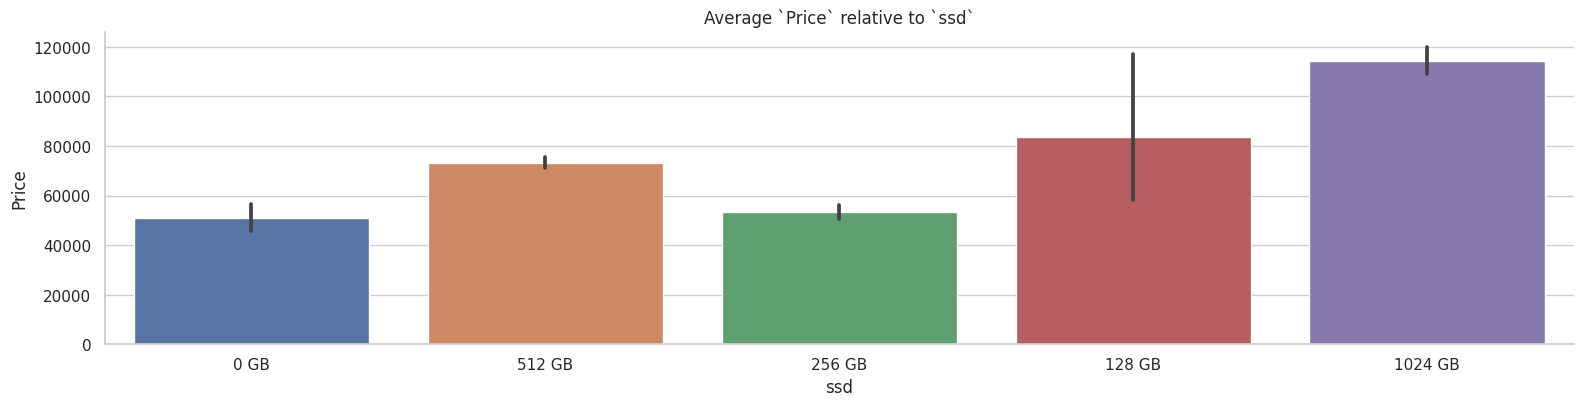

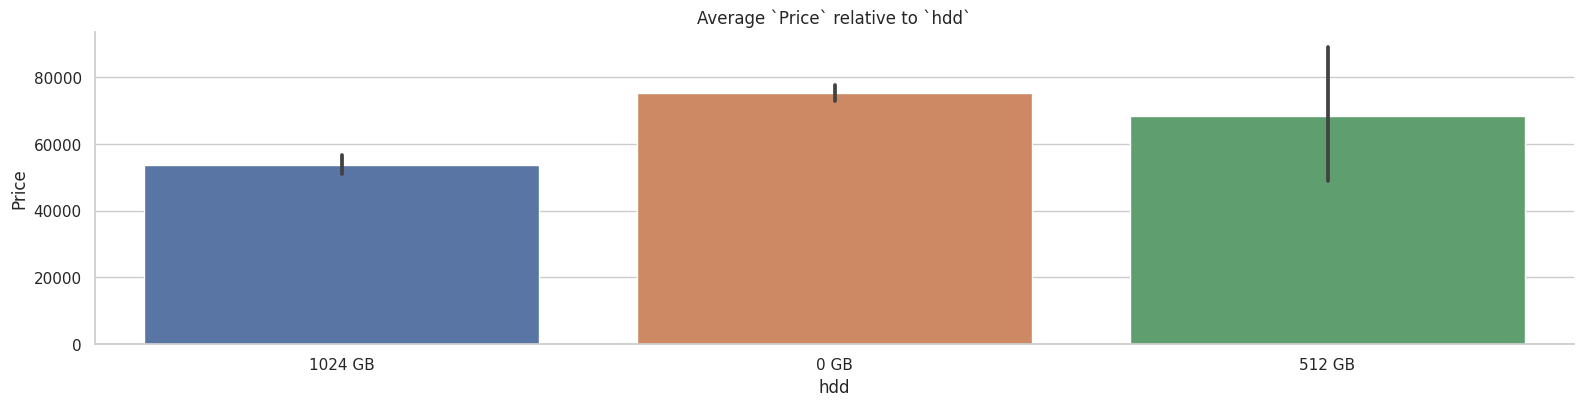

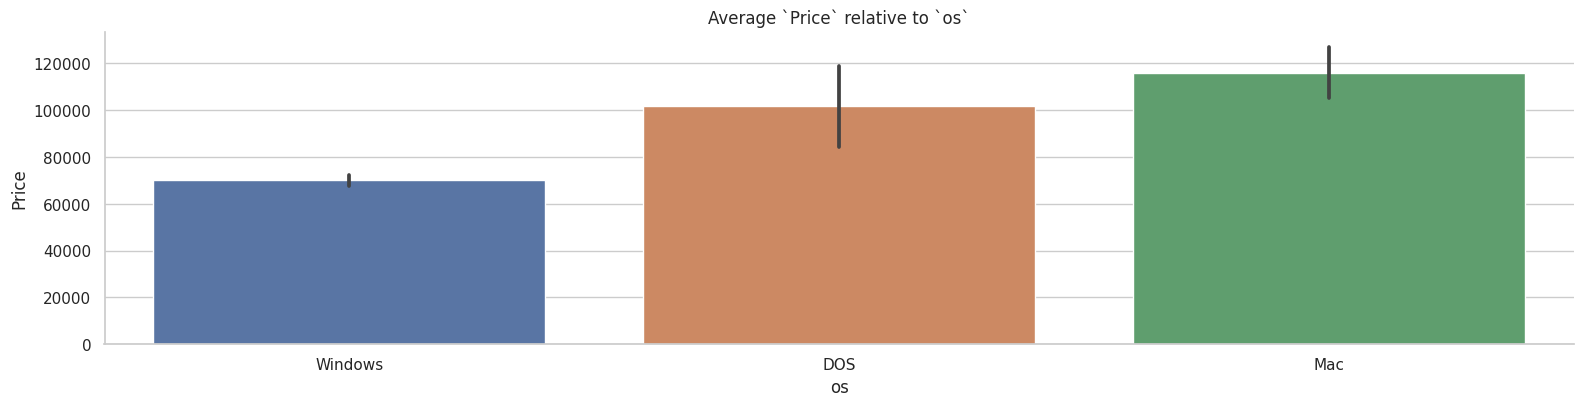

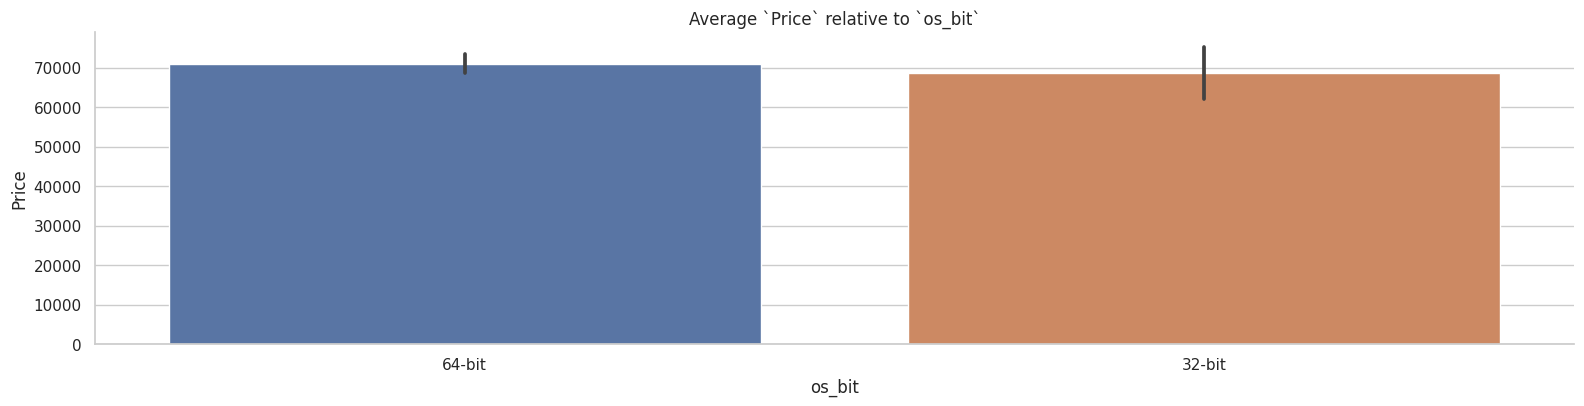

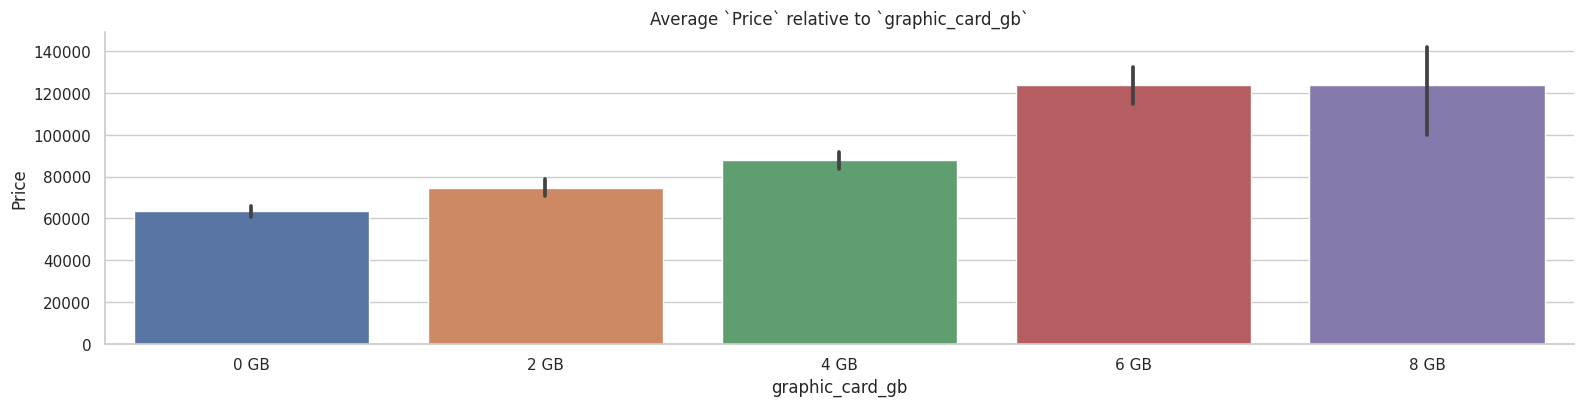

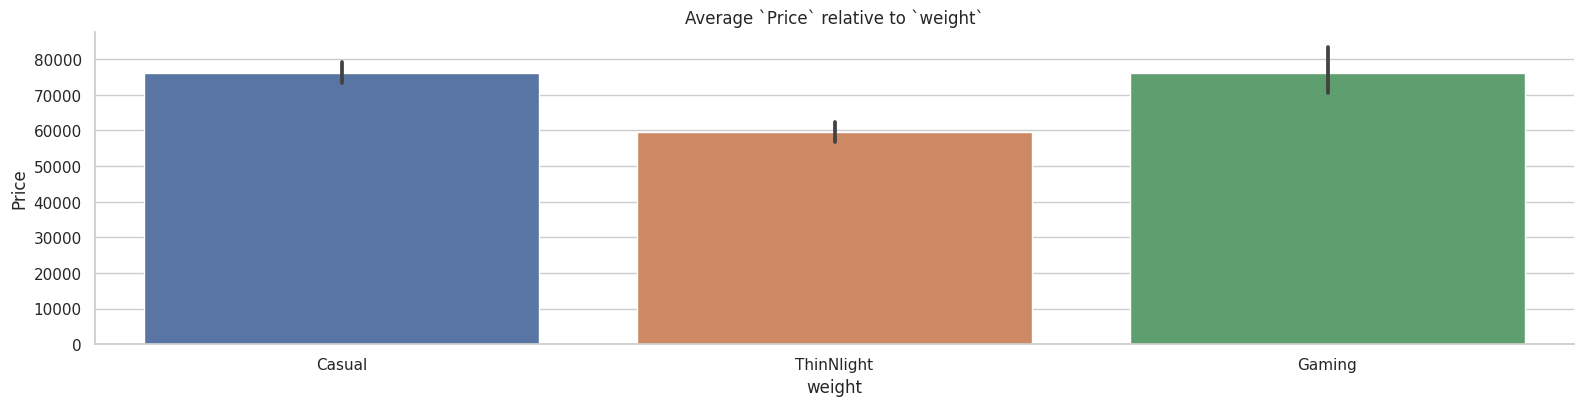

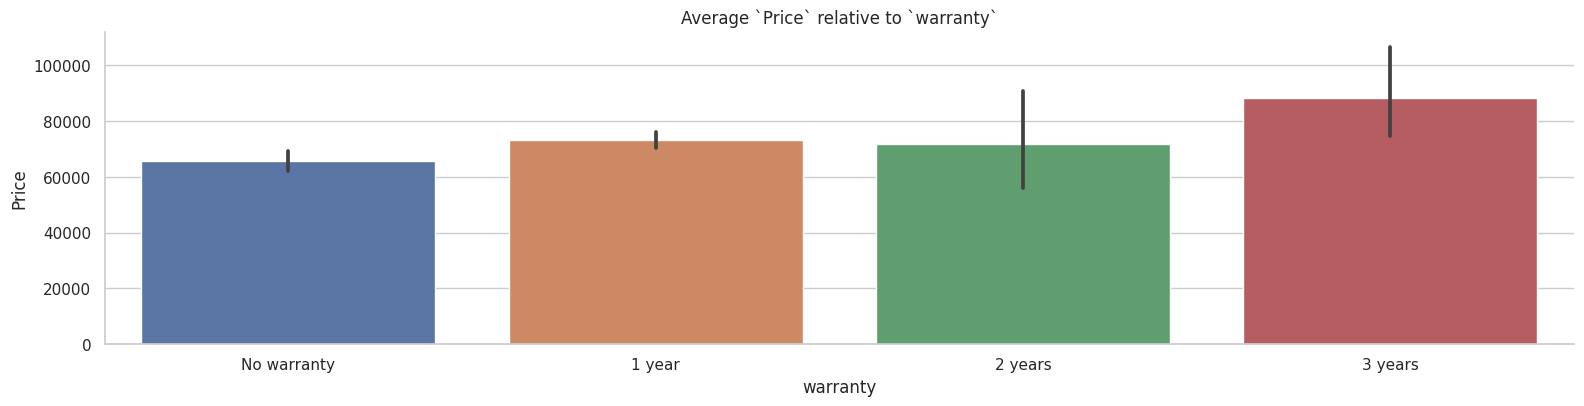

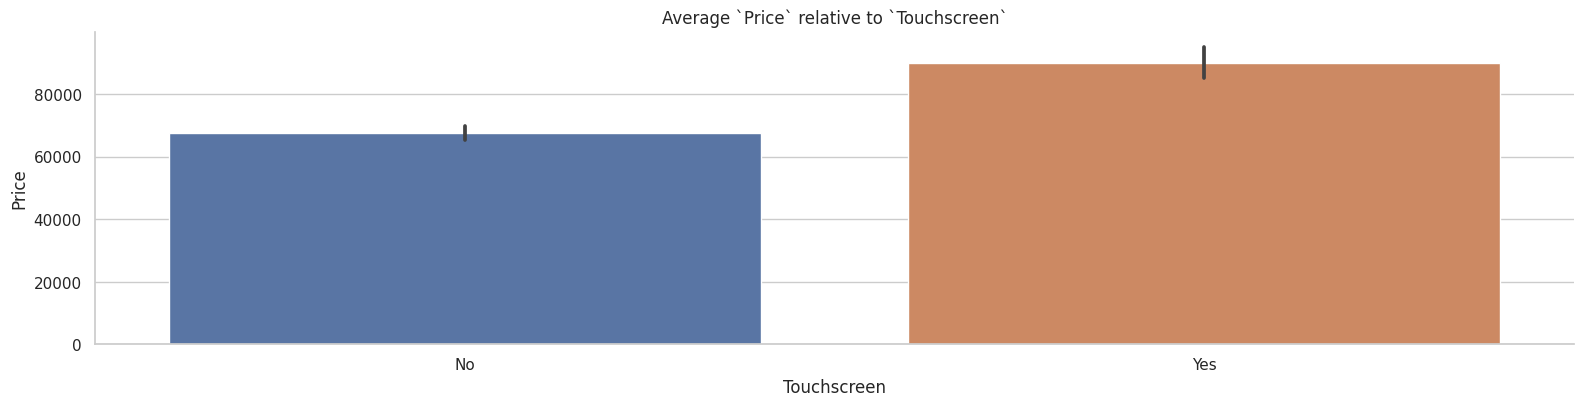

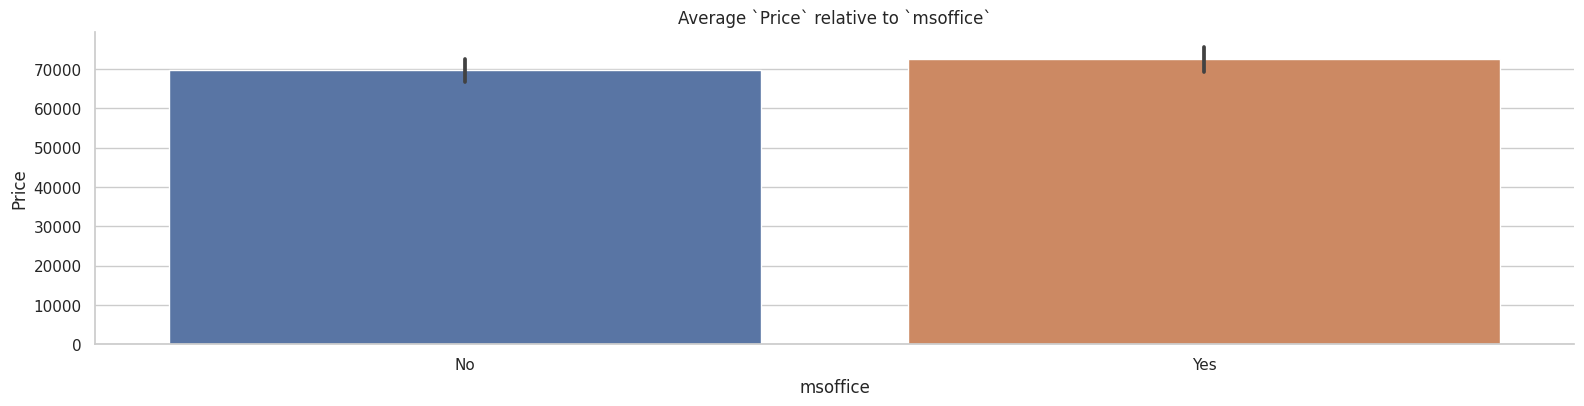

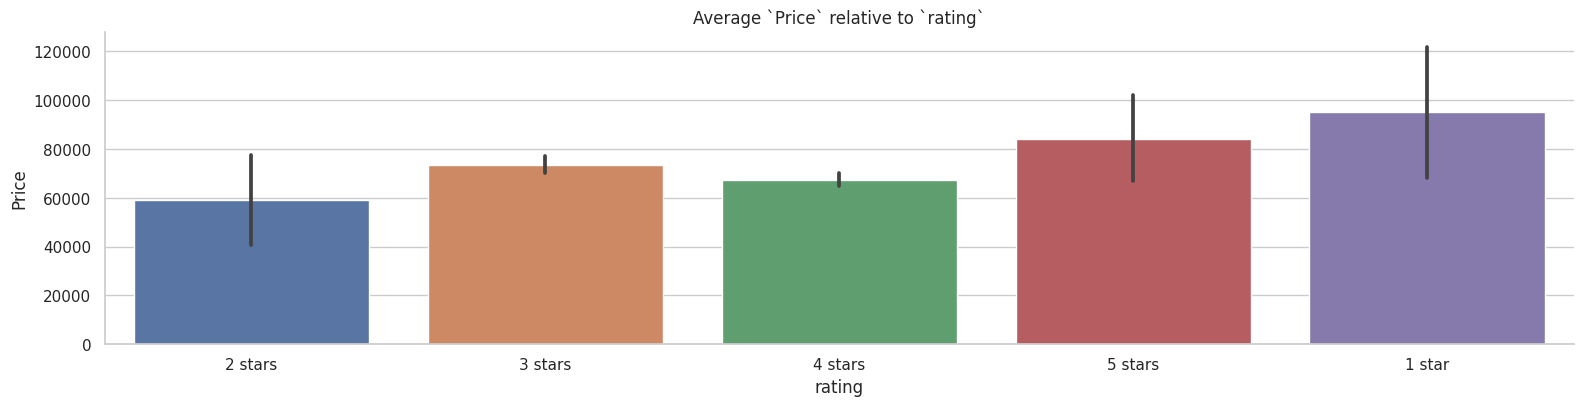

In [288]:
cat_features = df.select_dtypes(include='object').columns.to_list()

for col in cat_features:
  sns.catplot(x=col, y="Price", kind="bar", dodge=False, height=4, aspect=4, data=df)
  plt.title("Average `Price` relative to `{}`".format(col))

plt.show()

**Insights from the above plots:**

- From the `processor_name` feature, we can see that as the price increase, the higher the processor is
- There is increase in laptop price as the higher the graphic card specification.

Text(0.5, 1.0, 'Correlation Heatmap for Numerical Features')

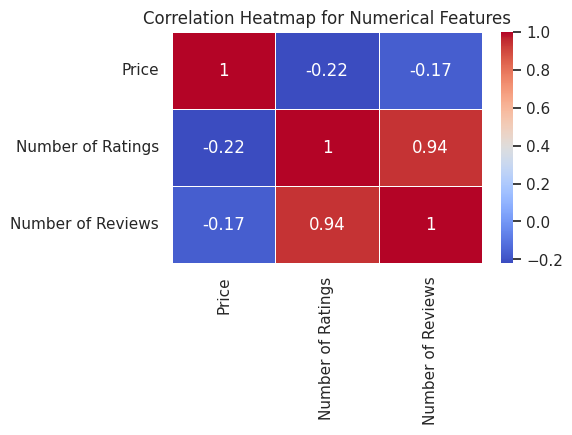

In [289]:
plt.figure(figsize=(5, 3))
correlation_matrix = df.corr().round(2)
 
sns.heatmap(data=correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, )
plt.title("Correlation Heatmap for Numerical Features")

**Insight from the above plot:**

- Even though it was previously stated that the `Number of Reviews` and `Number of Ratings` features don't have a high correlation with the `Price` column, based on the above correlation heatmap, the decision is to keep both features as both of them have absolute correlation value to the target column above 0.1.

# **Data Preparation**

## **1. Encode Categorical Features**

To be able to transform the categorical features to the numerical ones so that they can be fed into the model.

In [290]:
df = pd.get_dummies(data=df, columns=cat_features)
df.head()

,Price,Number of Ratings,Number of Reviews,brand_APPLE,brand_ASUS,brand_Avita,brand_DELL,brand_HP,brand_Lenovo,brand_MSI,...,warranty_No warranty,Touchscreen_No,Touchscreen_Yes,msoffice_No,msoffice_Yes,rating_1 star,rating_2 stars,rating_3 stars,rating_4 stars,rating_5 stars
0,34649,3,0,0,1,0,0,0,0,0,...,1,1,0,1,0,0,1,0,0,0
1,38999,65,5,0,0,0,0,0,1,0,...,1,1,0,1,0,0,0,1,0,0
2,39999,8,1,0,0,0,0,0,1,0,...,1,1,0,1,0,0,0,1,0,0
3,69990,0,0,0,1,0,0,0,0,0,...,1,1,0,1,0,0,0,1,0,0
4,26990,0,0,0,1,0,0,0,0,0,...,1,1,0,1,0,0,0,1,0,0


## **2. PCA**

To reduce the dimensionality of the data while still keeping most of the information on the data.

In [291]:
from sklearn.decomposition import PCA
 
pca = PCA(n_components=2, random_state=123)
pca.fit(df[['Number of Ratings', 'Number of Reviews']])

princ_comp = pca.transform(df[['Number of Ratings', 'Number of Reviews']])

In [292]:
pca.explained_variance_ratio_.round(3)

array([0.998, 0.002])

In [293]:
pca = PCA(n_components=1, random_state=123)

pca.fit(df[['Number of Ratings', 'Number of Reviews']])

df['num_feedback'] = pca.transform(df.loc[:, ('Number of Ratings', 'Number of Reviews')]).flatten()
df = df.drop(['Number of Ratings', 'Number of Reviews'], axis=1)

# **Data Splitting**

In [294]:
X = df.drop(['Price'], axis=1)
y = df['Price']

In [295]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [296]:
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (538, 74)
X_test shape: (96, 74)


# **Data Normalization**

In [297]:
scaler = StandardScaler()

num_cols = ['num_feedback']

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [298]:
X_train.head()

,brand_APPLE,brand_ASUS,brand_Avita,brand_DELL,brand_HP,brand_Lenovo,brand_MSI,brand_acer,processor_brand_AMD,processor_brand_Intel,...,Touchscreen_No,Touchscreen_Yes,msoffice_No,msoffice_Yes,rating_1 star,rating_2 stars,rating_3 stars,rating_4 stars,rating_5 stars,num_feedback
631,0,0,0,1,0,0,0,0,0,1,...,1,0,1,0,0,0,1,0,0,-0.588981
225,0,0,0,0,0,1,0,0,0,1,...,1,0,0,1,0,0,0,1,0,-0.340485
377,0,0,0,1,0,0,0,0,0,1,...,0,1,1,0,0,0,0,1,0,-0.356424
293,0,0,0,1,0,0,0,0,0,1,...,1,0,0,1,0,0,0,1,0,4.246709
757,0,0,0,0,0,1,0,0,1,0,...,1,0,0,1,0,0,0,1,0,0.920432


# **Modeling**

In [299]:
models = pd.DataFrame(index=['train_mae', 'test_mae'], 
                      columns=['rf', 'xgb'])

In [300]:
rfr = RandomForestRegressor()

rfr.fit(X_train, y_train)
 
models.loc['train_mae', 'rf'] = mean_absolute_error(y_pred=rfr.predict(X_train), y_true=y_train)

In [301]:
xgbr = xgb.XGBRegressor()

xgbr.fit(X_train, y_train)
 
models.loc['train_mae', 'xgb'] = mean_absolute_error(y_pred=xgbr.predict(X_train), y_true=y_train)

In [306]:
mae = pd.DataFrame(columns=['train', 'test'], index=['rf', 'xgb'])
 
model_dict = {'rf': rfr, 'xgb': xgbr}
 
for name, model in model_dict.items():
    mae.loc[name, 'train'] = mean_absolute_error(y_true=y_train, y_pred=model.predict(X_train))
    mae.loc[name, 'test'] = mean_absolute_error(y_true=y_test, y_pred=model.predict(X_test))

mae

,train,test
rf,3295.778792,7631.269655
xgb,1086.37863,7056.627808


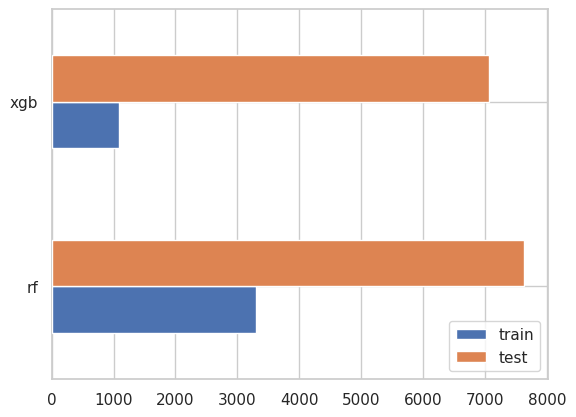

In [307]:
fig, ax = plt.subplots()
mae.sort_values(by='test', ascending=False).plot(kind='barh', ax=ax, zorder=3)
ax.grid(zorder=0)

In [308]:
prediction = X_test.iloc[:10]

pred_dict = {'y_true': y_test[:10]}

for name, model in model_dict.items():
  pred_dict['prediction_' + name] = model.predict(prediction).round(2)
 
pd.DataFrame(pred_dict)

,y_true,prediction_rf,prediction_xgb
491,77990,65956.79,64759.058594
317,70990,71592.10,76726.710938
280,61290,60828.02,61365.449219
440,48790,63820.69,55865.378906
724,59999,63540.21,60433.089844
519,99999,103608.78,104016.421875
775,72990,98379.30,98617.226562
316,106490,75484.92,84296.968750
74,48490,42195.49,42514.070312
278,59990,63163.52,57472.160156


In [309]:
mae_target = (df['Price'].max() - df['Price'].min()) * 0.1
print(round(mae_target, 4))

13210.8


# **Conclusion**

From the model evaluation, we can see that the MAE score of all the used models is all below 10%, with the XGBoost model that has the lowest MAE score. Therefore, it can be concluded that the model is a good fit.